# Denoising Autoencoder

## Introduction

What is denoising? The meaning is to remove the meaning of noise, which means that the autoencoder here to remove the noise input function. For example, the input image is not a clean image but a lot of white spots or broken (that is, noise), then the network there is a way to identify what the input image is called Denoising Autoencoder .

How to train denoising autoencoder? Simply input a manually added noise image, and then loss is the ** error of the autoencoder output image and the original image **, and minimize the error, the neural network Road can be done ** noise removal function.

The following will use a convolutional network structure to complete a denoising autoencoder. And use MNIST data to train it.


### Import required Packages and MNIST Data Set

In [2]:
from __future__ import division, print_function, absolute_import
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial, name)

def bias_variable(shape, name):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial, name)
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)
print("Packages loaded")

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Packages loaded


### Build helper functions

In [3]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 2, 2, 1], padding = 'SAME')

def deconv2d(x, W, output_shape):
    return tf.nn.conv2d_transpose(x, W, output_shape, strides = [1, 2, 2, 1], padding = 'SAME')

### Build compute graph

Notice that there are two placeholders established, one for the original image, the other for the x_noise, and the x_noise for the web.

In [5]:
def build_graph():
    x_origin = tf.reshape(x, [-1, 28, 28, 1])
    x_origin_noise = tf.reshape(x_noise, [-1, 28, 28, 1])

    W_e_conv1 = weight_variable([5, 5, 1, 16], "w_e_conv1")
    b_e_conv1 = bias_variable([16], "b_e_conv1")
    h_e_conv1 = tf.nn.relu(tf.add(conv2d(x_origin_noise, W_e_conv1), b_e_conv1))

    W_e_conv2 = weight_variable([5, 5, 16, 32], "w_e_conv2")
    b_e_conv2 = bias_variable([32], "b_e_conv2")
    h_e_conv2 = tf.nn.relu(tf.add(conv2d(h_e_conv1, W_e_conv2), b_e_conv2))

    code_layer = h_e_conv2
    print("code layer shape : %s" % h_e_conv2.get_shape())

    W_d_conv1 = weight_variable([5, 5, 16, 32], "w_d_conv1")
    b_d_conv1 = bias_variable([1], "b_d_conv1")
    output_shape_d_conv1 = tf.stack([tf.shape(x)[0], 14, 14, 16])
    h_d_conv1 = tf.nn.relu(deconv2d(h_e_conv2, W_d_conv1, output_shape_d_conv1))

    W_d_conv2 = weight_variable([5, 5, 1, 16], "w_d_conv2")
    b_d_conv2 = bias_variable([16], "b_d_conv2")
    output_shape_d_conv2 = tf.stack([tf.shape(x)[0], 28, 28, 1])
    h_d_conv2 = tf.nn.relu(deconv2d(h_d_conv1, W_d_conv2, output_shape_d_conv2))

    x_reconstruct = h_d_conv2
    print("reconstruct layer shape : %s" % x_reconstruct.get_shape())
    
    return x_origin, code_layer, x_reconstruct

tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape = [None, 784])
x_noise = tf.placeholder(tf.float32, shape = [None, 784])
x_origin, code_layer, x_reconstruct = build_graph()

code layer shape : (?, 7, 7, 32)
reconstruct layer shape : (?, ?, ?, ?)


### Build cost function

The way to calculate cost in the cost function is to calculate the mean square error of the output image and the original image.

In [6]:
cost = tf.reduce_mean(tf.pow(x_reconstruct - x_origin, 2))
optimizer = tf.train.AdamOptimizer(0.01).minimize(cost)

### Training (Add noise with coefficient 0.3)

During the training, the noise image is entered (parameter `0.3`) and the fall of the mean square error is observed.

During the test, enter a raw image to see how the output of the reconstruction affects the mean square error of the original image.

In [7]:
sess = tf.InteractiveSession()
batch_size = 50
init_op = tf.global_variables_initializer()
sess.run(init_op)


for epoch in range(10000):
    batch = mnist.train.next_batch(batch_size)
    batch_raw = batch[0]
    batch_noise = batch[0] + 0.3*np.random.randn(batch_size, 784)
    if epoch < 1500:
        if epoch%100 == 0:
            print("step %d, loss %g"%(epoch, cost.eval(feed_dict={x:batch_raw, x_noise: batch_noise})))
    else:
        if epoch%1000 == 0: 
            print("step %d, loss %g"%(epoch, cost.eval(feed_dict={x:batch_raw, x_noise: batch_noise})))
    
    optimizer.run(feed_dict={x:batch_raw, x_noise: batch_noise})
    
print("final loss %g" % cost.eval(feed_dict={x: mnist.test.images, x_noise: mnist.test.images}))

step 0, loss 0.11527
step 100, loss 0.0104102
step 200, loss 0.0088169
step 300, loss 0.00753967
step 400, loss 0.00773642
step 500, loss 0.00654976
step 600, loss 0.00695819
step 700, loss 0.00730943
step 800, loss 0.00631955
step 900, loss 0.00735634
step 1000, loss 0.0062637
step 1100, loss 0.00639213
step 1200, loss 0.00666016
step 1300, loss 0.00634009
step 1400, loss 0.00669537
step 2000, loss 0.00601513
step 3000, loss 0.00638407
step 4000, loss 0.00583356
step 5000, loss 0.00608094
step 6000, loss 0.00609358
step 7000, loss 0.00564113
step 8000, loss 0.00575735
step 9000, loss 0.00548561
final loss 0.00261247


### Plot reconstructed images

Use the test noise image that is not in the process of training to observe the result after denoising through the network.

In [8]:
def plot_n_reconstruct(origin_img, reconstruct_img, n = 10):

    plt.figure(figsize=(2 * 10, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(origin_img[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstruct_img[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

### Reconstructed images with coefficient 0.3

The result is very good

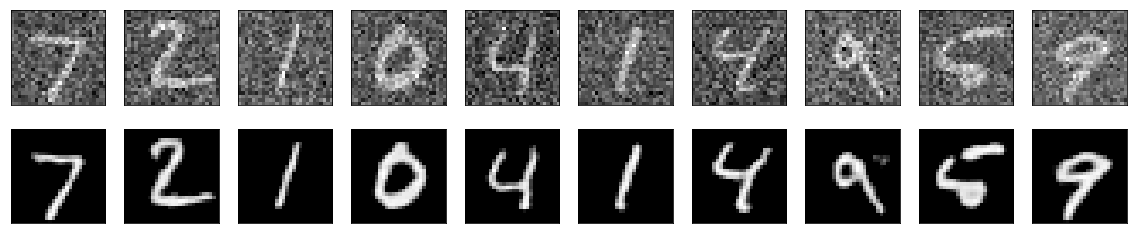

In [9]:
test_size = 10
test_origin_img = mnist.test.images[0:test_size, :]
test_reconstruct_img = np.reshape(x_reconstruct.eval(feed_dict = {x: test_origin_img, x_noise: test_origin_img + 0.3*np.random.randn(10, 784)}), [-1, 28 * 28])
plot_n_reconstruct(test_origin_img + 0.3*np.random.randn(10, 784), test_reconstruct_img)

### Reconstructed images with coefficient 0.5

The result has been a bit fuzzy

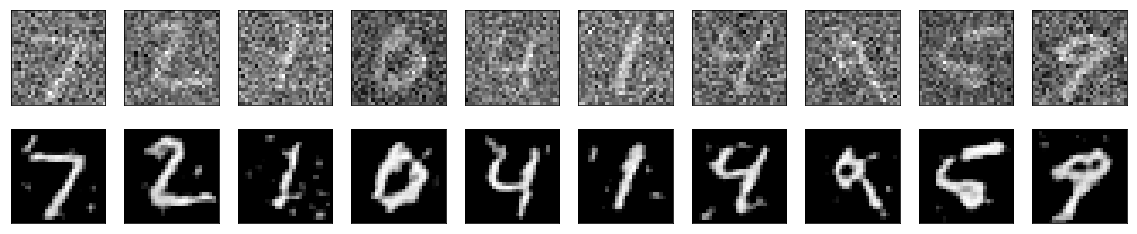

In [10]:
test_size = 10
test_origin_img = mnist.test.images[0:test_size, :]
test_reconstruct_img = np.reshape(x_reconstruct.eval(feed_dict = {x: test_origin_img, x_noise: test_origin_img + 0.5*np.random.randn(10, 784)}), [-1, 28 * 28])
plot_n_reconstruct(test_origin_img + 0.5*np.random.randn(10, 784), test_reconstruct_img)

### Reconstructed images with coefficient 0.7

Rapid change can not recognize it

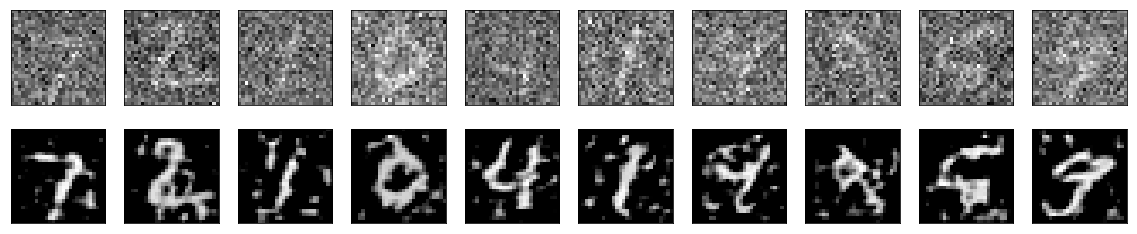

In [11]:
test_size = 10
test_origin_img = mnist.test.images[0:test_size, :]
test_reconstruct_img = np.reshape(x_reconstruct.eval(feed_dict = {x: test_origin_img, x_noise: test_origin_img + 0.7*np.random.randn(10, 784)}), [-1, 28 * 28])
plot_n_reconstruct(test_origin_img + 0.7*np.random.randn(10, 784), test_reconstruct_img)

### Reconstructed images with coefficient 0.9

Barely some texture.

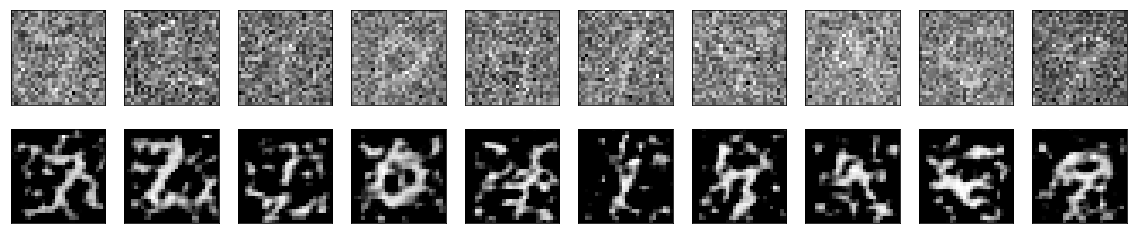

In [12]:
test_size = 10
test_origin_img = mnist.test.images[0:test_size, :]
test_reconstruct_img = np.reshape(x_reconstruct.eval(feed_dict = {x: test_origin_img, x_noise: test_origin_img + 0.9*np.random.randn(10, 784)}), [-1, 28 * 28])
plot_n_reconstruct(test_origin_img + 0.9*np.random.randn(10, 784), test_reconstruct_img)